# Developing a unified representation of Alzheimer’s subtypes

# Part 3: Cluster Correlation Assessment

After isolating the data per modality with each subject being assigned a subtype and stage this notebook will assess the different subtype correlation. 
MRI we found 4 cluster, AB 2 and TAU 4. 
I will run individual assessments between modalities and see if I can isolate unified representations of AD subtypes. 

## Import Packages 

In [3]:
# import the python packages needed to generate simulated data for the tutorial
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pySuStaIn
import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.stats.anova import anova_lm
from scipy import stats
from scipy.stats import linregress
from scipy.stats import spearmanr
from scipy.interpolate import make_interp_spline
from scipy.stats import kendalltau
from scipy.interpolate import PchipInterpolator
import sklearn.model_selection
import sys
import shutil
import math
import warnings
warnings.filterwarnings("ignore", category=UserWarning, message=".*figure layout has changed to tight.*")
from itertools import combinations, product
from pathlib import Path
import pickle


sys.path.insert(0,'/Users/yuvalkesselmeilichson/Documents/Anaconda/Project/pySuStaIn/notebooks/')

## 1. reading relevant data: 

In [4]:
zdata_mri = pd.read_csv("Train_MRI_SuStaIn_1.csv")
zdata_mri['Modality'] = 'MRI'

zdata_ab = pd.read_csv("Train_AB_SuStaIn_2.csv")
zdata_ab['Modality'] = 'AB'

zdata_tau = pd.read_csv("Train_TAU_SuStaIn_3.csv")
zdata_tau['Modality'] = 'TAU'


In [5]:
def standardize_label(label, modality):
    # Map known patterns to standardized lobe names
    lobe_map = {
        "mtl": "MTL",
        "temporal": "Temporal_Lobe",
        "parietal": "Parietal_Lobe",
        "frontal": "Frontal_Lobe",
        "occipital": "Occipital_Lobe"
    }

    # Lowercase and remove suffixes
    label_clean = (
        label.lower()
        .replace("_suvr_weighted", "")
        .replace("_volume", "")
        .replace("_suvr", "")
        .replace("_weighted_tau", "")
        .replace("_", "")
    )

    # Match lobe name
    for key in lobe_map:
        if key in label_clean:
            return f"{lobe_map[key]}"
    
    return f"UnknownLobe"


In [6]:
#Sustain data per modality
N_startpoints = 50

#MRI
N_S_max_mri = 4
N_iterations_MCMC = int(1e5)
output_folder_mri = os.path.join(os.getcwd(), 'MRIOutput')
dataset_name_mri = 'MRIOutput'
pickle_filename_s_mri = output_folder_mri + '/pickle_files/' + dataset_name_mri + '_subtype' + str(N_S_max_mri-1) + '.pickle'
pk_mri = pd.read_pickle(pickle_filename_s_mri)
samples_sequence_mri = pk_mri["samples_sequence"]
samples_f_mri = pk_mri["samples_f"]

biomarkers_mri = ['Frontal_lobe_volume', 'Occipital_lobe_volume', 'Parietal_lobe_volume','Temporal_lobe_volume', 'MTL_volume']
N_mri = len(biomarkers_mri)    
SuStaInLabels_mri = [standardize_label(b, "MRI") for b in biomarkers_mri]
Z_vals_mri = np.array([[2,3,4.5]]*N_mri)     # Z-scores for each biomarker
Z_max_mri  = np.ceil(np.percentile(zdata_mri[biomarkers_mri].values,99,axis=0)).astype('int')           # maximum z-score

sustain_input_mri = pySuStaIn.ZscoreSustain(
                              zdata_mri[biomarkers_mri].values,
                              Z_vals_mri,
                              Z_max_mri,
                              SuStaInLabels_mri,
                              N_startpoints,
                              N_S_max_mri, 
                              N_iterations_MCMC, 
                              output_folder_mri, 
                              dataset_name_mri, 
                              False)

pickle_filepath_mri             = Path(pickle_filename_s_mri)
pickle_file_mri                 = open(pickle_filename_s_mri, 'rb')
loaded_variables_mri            = pickle.load(pickle_file_mri)
ml_subtype_mri                  = loaded_variables_mri["ml_subtype"]
prob_ml_subtype_mri             = loaded_variables_mri["prob_ml_subtype"]
ml_stage_mri                    = loaded_variables_mri["ml_stage"]
prob_ml_stage_mri               = loaded_variables_mri["prob_ml_stage"]
prob_subtype_mri                = loaded_variables_mri["prob_subtype"]
prob_stage_mri                  = loaded_variables_mri["prob_stage"]
prob_subtype_stage_mri          = loaded_variables_mri["prob_subtype_stage"]
ml_seq_mri                      = loaded_variables_mri["ml_sequence_EM"]
pickle_file_mri.close()    

#AB
N_S_max_ab = 2
output_folder_ab = os.path.join(os.getcwd(), 'ABOutput')
dataset_name_ab = 'ABOutput'
pickle_filename_s_ab = output_folder_ab + '/pickle_files/' + dataset_name_ab + '_subtype' + str(N_S_max_ab-1) + '.pickle'
pk_ab = pd.read_pickle(pickle_filename_s_ab)
samples_sequence_ab = pk_ab["samples_sequence"]
samples_f_ab = pk_ab["samples_f"]

biomarkers_ab = ['Frontal_lobe_SUVR_weighted_ab', 'Occipital_lobe_SUVR_weighted_ab','Parietal_lobe_SUVR_weighted_ab', 'Temporal_lobe_SUVR_weighted_ab','MTL_SUVR_weighted_ab']
N_ab = len(biomarkers_ab)      
SuStaInLabels_ab = [standardize_label(b, "AB") for b in biomarkers_ab]
Z_vals_ab = np.array([[1,2,3.5]]*N_ab)     # Z-scores for each biomarker
Z_max_ab  = np.ceil(np.percentile(zdata_ab[biomarkers_ab].values,99,axis=0)).astype('int')           # maximum z-score
sustain_input_ab = pySuStaIn.ZscoreSustain(
                              zdata_ab[biomarkers_ab].values,
                              Z_vals_ab,
                              Z_max_ab,
                              SuStaInLabels_ab,
                              N_startpoints,
                              N_S_max_ab, 
                              N_iterations_MCMC, 
                              output_folder_ab, 
                              dataset_name_ab, 
                              False)

pickle_filepath_ab             = Path(pickle_filename_s_ab)
pickle_file_ab                 = open(pickle_filename_s_ab, 'rb')
loaded_variables_ab            = pickle.load(pickle_file_ab)
ml_subtype_ab                  = loaded_variables_ab["ml_subtype"]
prob_ml_subtype_ab             = loaded_variables_ab["prob_ml_subtype"]
ml_stage_ab                    = loaded_variables_ab["ml_stage"]
prob_ml_stage_ab               = loaded_variables_ab["prob_ml_stage"]
prob_subtype_ab                = loaded_variables_ab["prob_subtype"]
prob_stage_ab                  = loaded_variables_ab["prob_stage"]
prob_subtype_stage_ab          = loaded_variables_ab["prob_subtype_stage"]
ml_seq_ab                      = loaded_variables_ab["ml_sequence_EM"]
pickle_file_ab.close()              


#TAU
N_S_max_tau = 4
output_folder_tau = os.path.join(os.getcwd(), 'TAUOutput')
dataset_name_tau = 'TAUOutput'
pickle_filename_s_tau = output_folder_tau + '/pickle_files/' + dataset_name_tau + '_subtype' + str(N_S_max_tau-1) + '.pickle'
pk_tau = pd.read_pickle(pickle_filename_s_tau)
samples_sequence_tau = pk_tau["samples_sequence"]
samples_f_tau = pk_tau["samples_f"]

biomarkers_tau = ['Frontal_lobe_SUVR_weighted_tau', 'Occipital_lobe_SUVR_weighted_tau', 'Parietal_lobe_SUVR_weighted_tau', 'Temporal_lobe_SUVR_weighted_tau', 'MTL_SUVR_weighted_tau']
N_tau = len(biomarkers_tau)         
SuStaInLabels_tau = [standardize_label(b, "TAU") for b in biomarkers_tau]
Z_vals_tau = np.array([[3,5,6.5]]*N_tau)     # Z-scores for each biomarker
Z_max_tau  = np.ceil(np.nanpercentile(zdata_tau[biomarkers_tau].values,99,axis=0)).astype('int')           # maximum z-score

sustain_input_tau = pySuStaIn.ZscoreSustain(
                              zdata_tau[biomarkers_tau].values,
                              Z_vals_tau,
                              Z_max_tau,
                              SuStaInLabels_tau,
                              N_startpoints,
                              N_S_max_tau, 
                              N_iterations_MCMC, 
                              output_folder_tau, 
                              dataset_name_tau, 
                              False)

pickle_filepath_tau             = Path(pickle_filename_s_tau)
pickle_file_tau                 = open(pickle_filename_s_tau, 'rb')
loaded_variables_tau            = pickle.load(pickle_file_tau)
ml_subtype_tau                  = loaded_variables_tau["ml_subtype"]
prob_ml_subtype_tau             = loaded_variables_tau["prob_ml_subtype"]
ml_stage_tau                    = loaded_variables_tau["ml_stage"]
prob_ml_stage_tau               = loaded_variables_tau["prob_ml_stage"]
prob_subtype_tau                = loaded_variables_tau["prob_subtype"]
prob_stage_tau                  = loaded_variables_tau["prob_stage"]
prob_subtype_stage_tau          = loaded_variables_tau["prob_subtype_stage"]
ml_seq_tau                      = loaded_variables_tau["ml_sequence_EM"]
pickle_file_tau.close()              


## 2. Assess subtype correlation
To assess the correlation between subtpes we need a common basis for comparison, a progression pattern signature that captures when and how strongly each lobe becomes abnormal across subtypes and stages. 

To do this I defined four functions: 
1. Computes the lobe progression per subtypes per stage by giving the lobe with the highest zscore per stage to the overall subtype from SuStaIn. -Progression Pattern Signature. 
2. Correlates between subtypes between different modalities based on the signatures.

In [7]:
def sort_subtypes_by_frequency(sequences, subtype_assignments):
    unique, counts = np.unique(subtype_assignments, return_counts=True)
    sorted_indices = np.argsort(-counts)  # Descending order
    sorted_sequences = [sequences[i] for i in sorted_indices]
    sorted_counts = counts[np.argsort(-counts)]
    index_map = {old: new for new, old in enumerate(sorted_indices)}
    return sorted_sequences, sorted_counts, index_map


# Your subject subtype assignments per modality (make sure these exist)
subject_assignments = {
    'MRI': ml_subtype_mri,
    'AB': ml_subtype_ab,
    'TAU': ml_subtype_tau
}

# === Define your inputs: each modality's sustain input and sequences ===
modalities = {
    'MRI': {
        'sustain_input': sustain_input_mri,
        'sequences': ml_seq_mri
    },
    'AB': {
        'sustain_input': sustain_input_ab,
        'sequences': ml_seq_ab
    },
    'TAU': {
        'sustain_input': sustain_input_tau,
        'sequences': ml_seq_tau
    }
}

# Define known z-score stages per modality
known_zs_dict = {
    'MRI': [2.00, 3.00, 4.50],
    'AB': [1.00, 2.00, 3.50],
    'TAU': [3.00, 5.00, 6.50]
}

z_stage_map = {0: "1st", 1: "2nd", 2: "3rd"}

all_progressions = {}

for modality, info in modalities.items():
    sustain_input = info['sustain_input']
    sequences = info['sequences']
    assignments = subject_assignments[modality]

    # Use modality-specific known z-scores
    known_zs = known_zs_dict.get(modality)
    if known_zs is None:
        print(f"Warning: No known_zs defined for modality {modality}, skipping...")
        continue

    # Sort sequences by subject counts per subtype
    sorted_sequences, counts, idx_map = sort_subtypes_by_frequency(sequences, assignments)

    idxs = sustain_input.stage_biomarker_index[0]
    zvals = sustain_input.stage_zscore[0]
    labs = sustain_input.biomarker_labels.copy()

    print(f"\n==== {modality} Subtype Sequences (Sorted by Subject Count) ====")

    modality_progressions = []
    for i, st_seq in enumerate(sorted_sequences, start=1):
        print(f"\nSubtype {i} (n={counts[i-1]} subjects):")
        readable_seq = []
        for k in st_seq:
            idx = idxs[int(k)]
            z = zvals[int(k)]
            raw_label = labs[int(idx)]

            # Standardize lobe name
            lobe = standardize_label(raw_label, modality)

            # Assign to closest z-score stage for this modality
            closest_idx = np.argmin([abs(z - known) for known in known_zs])
            stage = z_stage_map[closest_idx]

            final_label = f"{stage}: {lobe}"
            print(final_label)
            readable_seq.append(final_label)

        modality_progressions.append(readable_seq)

    all_progressions[modality] = modality_progressions



==== MRI Subtype Sequences (Sorted by Subject Count) ====

Subtype 1 (n=1252 subjects):
1st: MTL
2nd: MTL
3rd: MTL
1st: Temporal_Lobe
2nd: Temporal_Lobe
1st: Parietal_Lobe
1st: Frontal_Lobe
2nd: Frontal_Lobe
2nd: Parietal_Lobe
3rd: Frontal_Lobe
3rd: Parietal_Lobe
1st: Occipital_Lobe
2nd: Occipital_Lobe
3rd: Occipital_Lobe
3rd: Temporal_Lobe

Subtype 2 (n=20 subjects):
1st: Parietal_Lobe
2nd: Parietal_Lobe
3rd: Parietal_Lobe
1st: Occipital_Lobe
2nd: Occipital_Lobe
3rd: Occipital_Lobe
1st: Temporal_Lobe
2nd: Temporal_Lobe
3rd: Temporal_Lobe
1st: Frontal_Lobe
2nd: Frontal_Lobe
3rd: Frontal_Lobe
1st: MTL
2nd: MTL
3rd: MTL

Subtype 3 (n=13 subjects):
1st: Frontal_Lobe
2nd: Frontal_Lobe
3rd: Frontal_Lobe
1st: Parietal_Lobe
2nd: Parietal_Lobe
3rd: Parietal_Lobe
1st: Occipital_Lobe
2nd: Occipital_Lobe
3rd: Occipital_Lobe
1st: Temporal_Lobe
2nd: Temporal_Lobe
3rd: Temporal_Lobe
1st: MTL
2nd: MTL
3rd: MTL

Subtype 4 (n=8 subjects):
1st: Occipital_Lobe
2nd: Occipital_Lobe
3rd: Occipital_Lobe
1st

In [8]:
def build_progression_from_readable(all_progressions, modality, known_zs_dict):
    lobes = ['Frontal_Lobe', 'Occipital_Lobe', 'Parietal_Lobe', 'Temporal_Lobe', 'MTL']
    sequences = all_progressions[modality]
    n_stages = len(sequences[0]) + 1  # Add stage 0

    # Map stage label to z-score for the modality
    stage_label_to_z = {
        "1st": known_zs_dict[modality][0],
        "2nd": known_zs_dict[modality][1],
        "3rd": known_zs_dict[modality][2],
    }

    modality_progression = {}

    for subtype_idx, sequence in enumerate(sequences):
        # Initialize with stage 0 all zeros
        lobe_zscores = {lobe: [0] for lobe in lobes}

        for stage_idx, item in enumerate(sequence):
            # item example: "2nd: MTL"
            try:
                stage_label, lobe = item.split(": ")
                stage_label = stage_label.strip()
                lobe = lobe.strip()
            except Exception as e:
                print(f"Warning: Unexpected format '{item}'")
                continue

            z = stage_label_to_z.get(stage_label, np.nan)

            # Extend list to current stage + 1 (account for stage 0)
            while len(lobe_zscores[lobe]) <= stage_idx:
                lobe_zscores[lobe].append(np.nan)
            
            lobe_zscores[lobe].append(z)

        # Fill missing entries for each lobe to n_stages
        for lobe in lobes:
            while len(lobe_zscores[lobe]) < n_stages:
                lobe_zscores[lobe].append(np.nan)

        # Forward fill NaNs (stage progression)
        for lobe in lobes:
            for k in range(1, n_stages):
                if np.isnan(lobe_zscores[lobe][k]):
                    lobe_zscores[lobe][k] = lobe_zscores[lobe][k-1]

        # Replace remaining NaNs with zero
        for lobe in lobes:
            lobe_zscores[lobe] = [0 if np.isnan(x) else x for x in lobe_zscores[lobe]]

        modality_progression[subtype_idx] = lobe_zscores

    return modality_progression


def plot_progression_signatures(progression_dict, modality_name):
    lobes = ['Frontal_Lobe', 'Occipital_Lobe', 'Parietal_Lobe', 'Temporal_Lobe', 'MTL']
    n_subtypes = len(progression_dict)

    for subtype in range(n_subtypes):
        plt.figure(figsize=(10, 6))

        for lobe in lobes:
            scores = progression_dict[subtype][lobe]
            scores = np.array(scores)

            # Replace NaN with 0
            scores = np.nan_to_num(scores, nan=0.0)
            stages = np.arange(len(scores))

            # Enforce non-negative and non-decreasing
            for i in range(1, len(scores)):
                scores[i] = max(scores[i], scores[i - 1])

            # Interpolate
            interpolator = PchipInterpolator(stages, scores, extrapolate=False)
            fine_stages = np.linspace(0, len(scores) - 1, 300)
            smooth_scores = interpolator(fine_stages)

            # Clip final interpolation result
            smooth_scores = np.clip(smooth_scores, 0, np.nanmax(scores))

            plt.plot(fine_stages, smooth_scores, label=lobe)

        plt.title(f"{modality_name} - Subtype {subtype + 1}")
        plt.xticks(np.arange(len(scores)))  # 0 to 15
        plt.xlabel("Disease Stage", fontsize=12)
        plt.ylabel("Z-score", fontsize=12)
        plt.ylim(0, np.nanmax(scores) + 0.5)
        plt.grid(True)
        plt.legend()
        plt.tight_layout()
        plt.show()


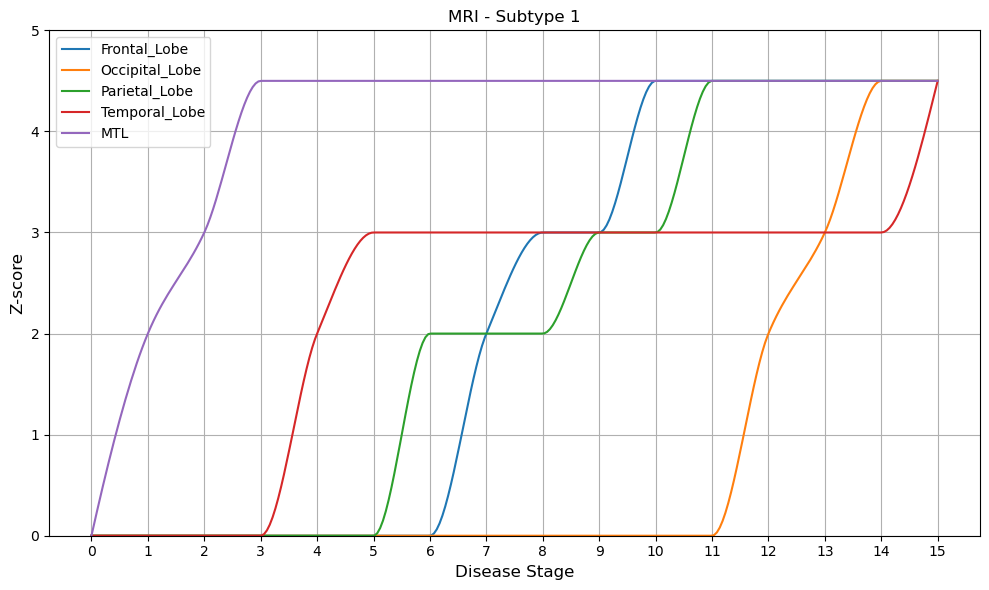

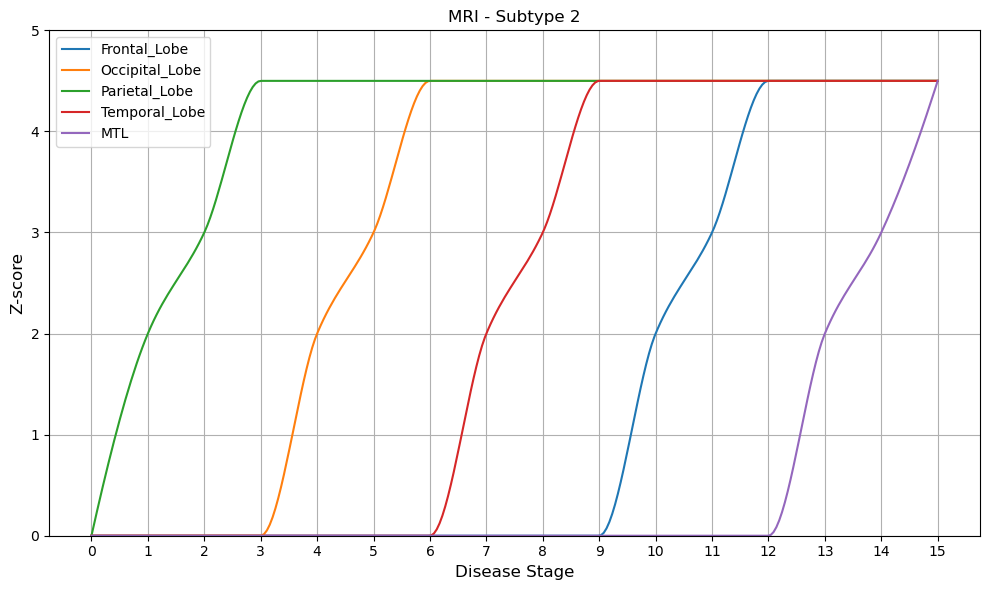

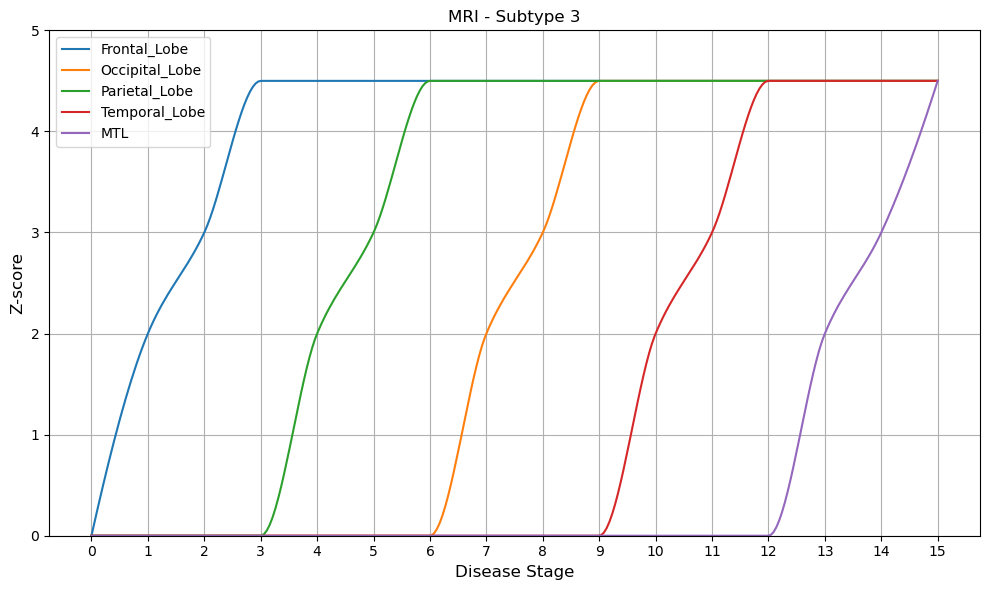

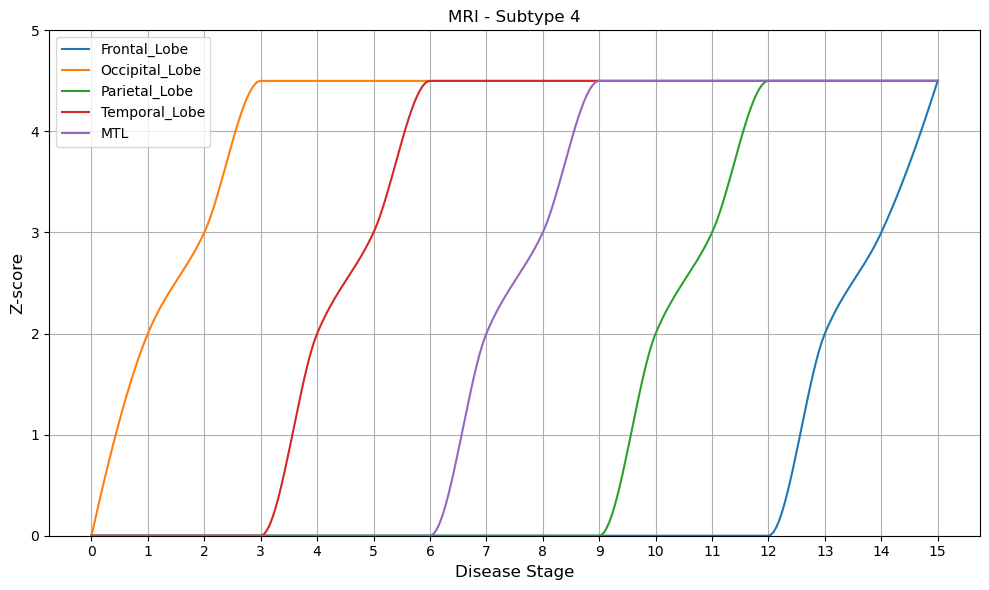

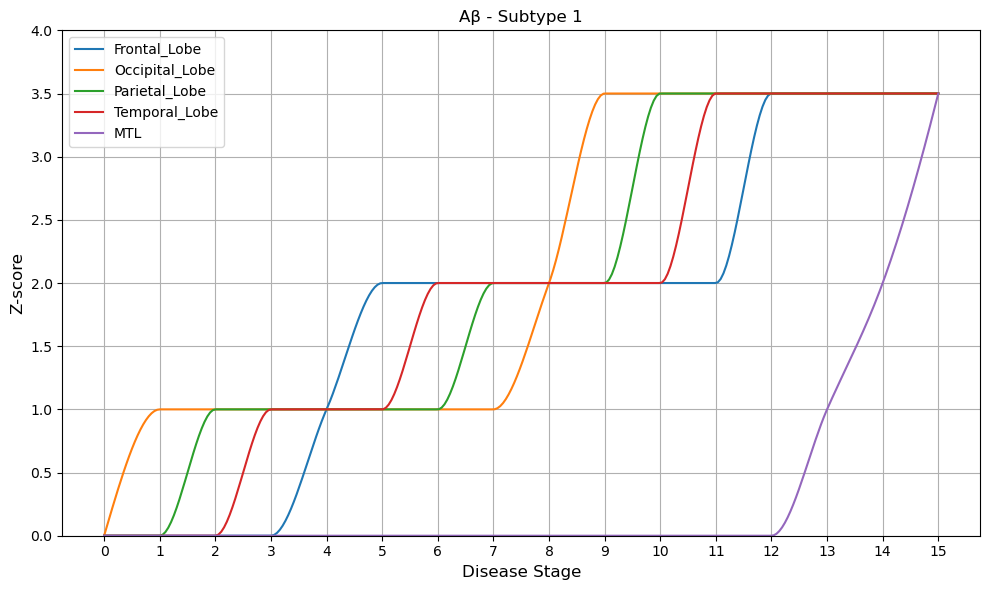

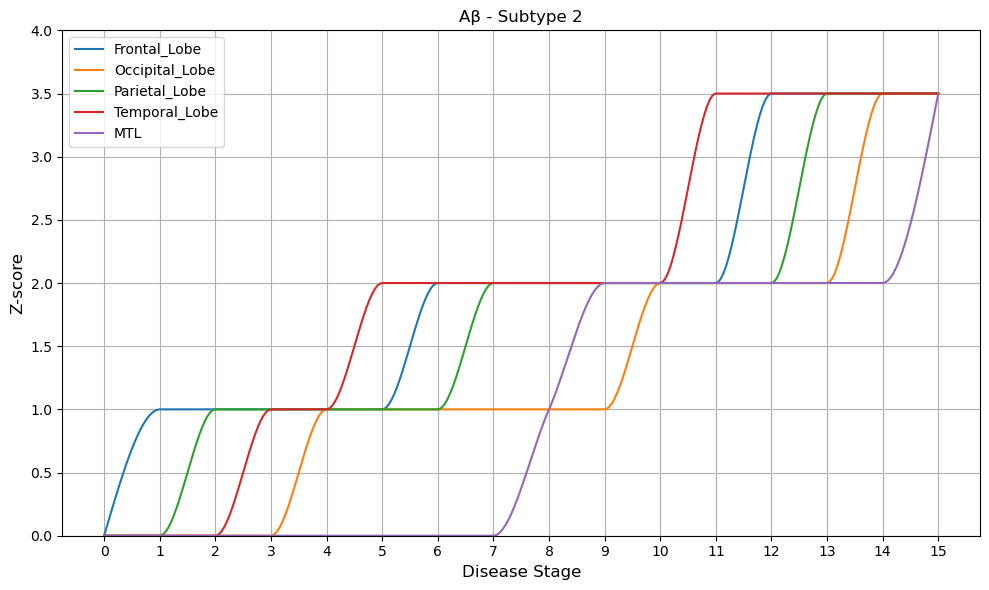

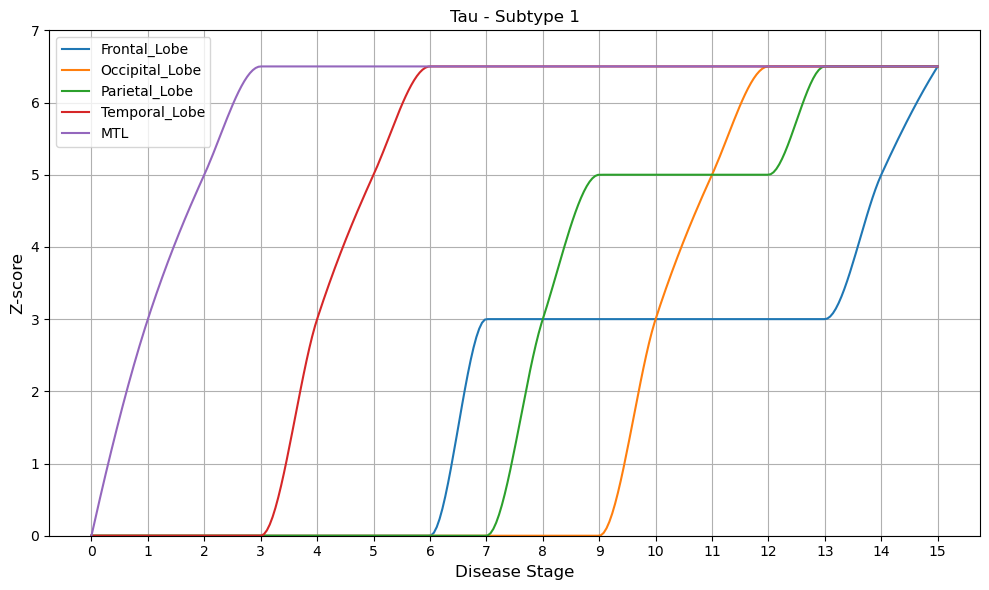

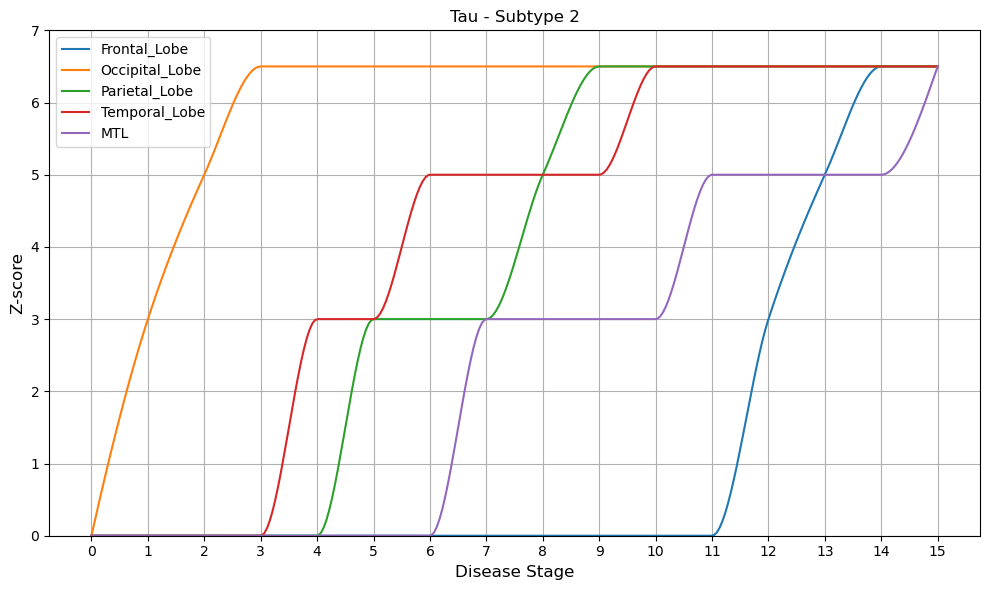

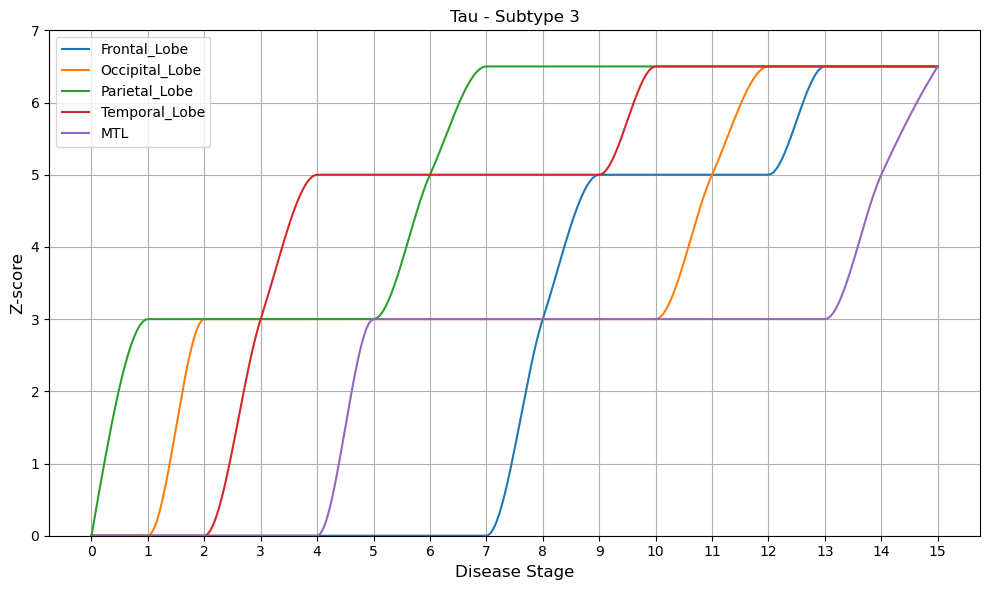

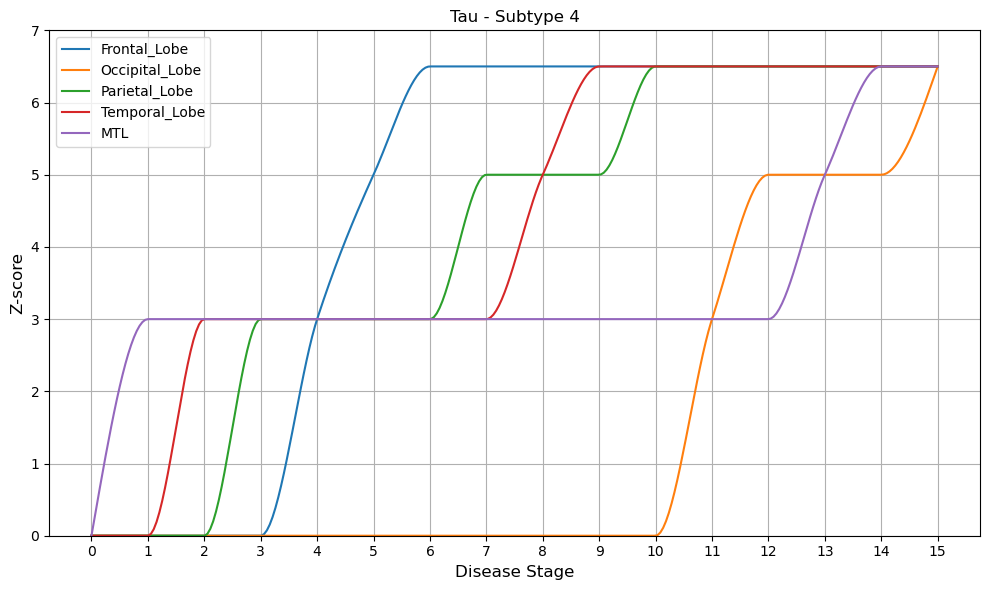

In [9]:
progression_mri = build_progression_from_readable(all_progressions, 'MRI', known_zs_dict)
progression_ab = build_progression_from_readable(all_progressions, 'AB', known_zs_dict)
progression_tau = build_progression_from_readable(all_progressions, 'TAU', known_zs_dict)



plot_progression_signatures(progression_mri, "MRI")
plot_progression_signatures(progression_ab, "Aβ")
plot_progression_signatures(progression_tau, "Tau")


In [10]:
# Create individual lists for each subtype signature progression order
modality_prefixes = {
    'MRI': 'mri',
    'AB': 'ab',
    'TAU': 'tau'
}

all_subtype_full_sequences = {}

for modality, subtype_seqs in all_progressions.items():
    prefix = modality_prefixes.get(modality, modality.lower())
    for i, seq in enumerate(subtype_seqs, start=1):
        var_name = f"{prefix}_subtype_{i}"
        globals()[var_name] = seq  # assign full sequence (with stages)
        all_subtype_full_sequences[var_name] = seq




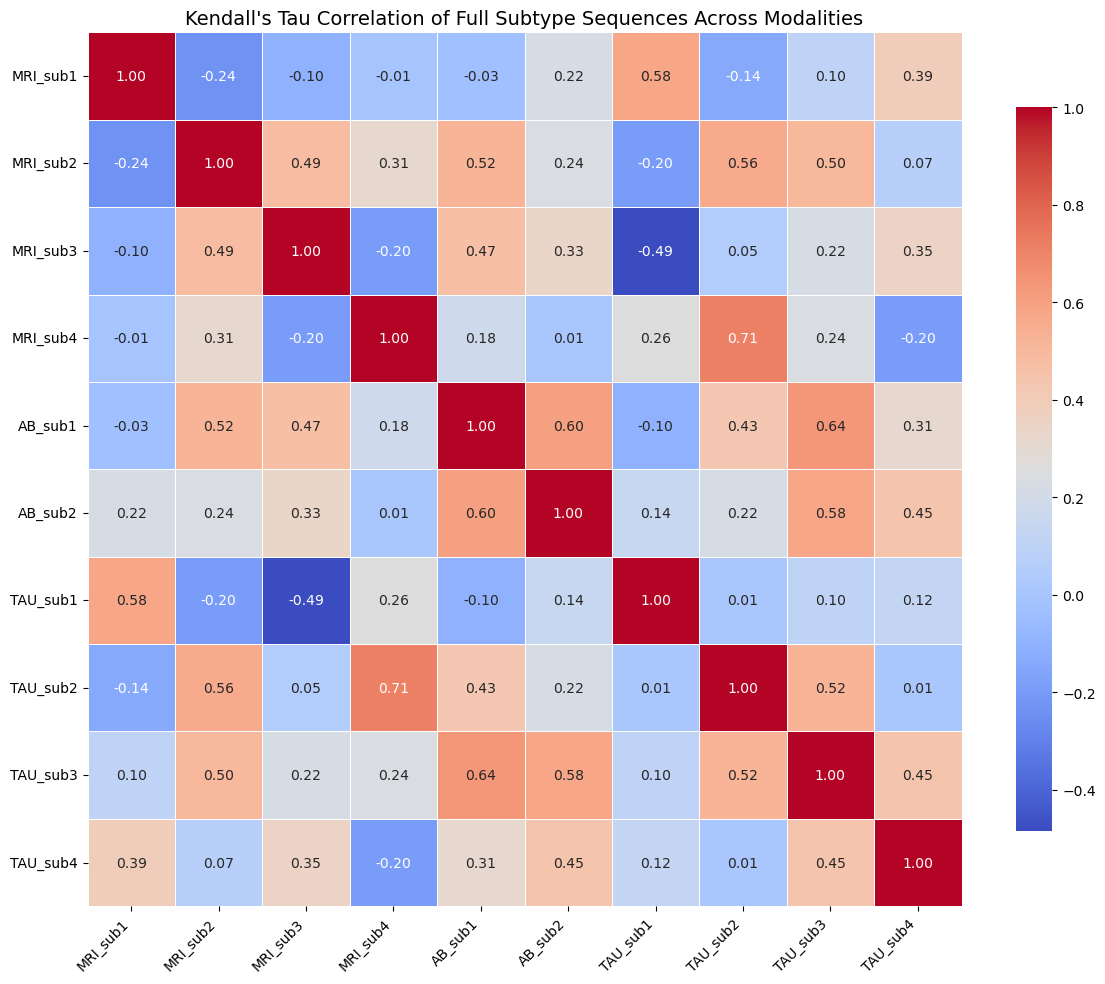

In [11]:
# Flatten all unique entries (stage + lobe) across all sequences
all_entries = set()
for modality, subtype_seqs in all_progressions.items():
    for seq in subtype_seqs:
        all_entries.update(seq)

all_entries = sorted(all_entries)  # sorted for consistent ordering
entry_index = {entry: idx for idx, entry in enumerate(all_entries)}

def sequence_to_rank_vector_full(seq):
    """
    Convert a subtype sequence (list of full strings 'stage: lobe') into a rank vector over all possible entries.
    If an entry is missing in the sequence, assign rank = len(seq)+1 (last).
    """
    n_entries = len(all_entries)
    rank_vector = np.full(n_entries, len(seq) + 1, dtype=int)
    for rank, entry in enumerate(seq, start=1):
        if entry in entry_index:
            rank_vector[entry_index[entry]] = rank
    return rank_vector

# Prepare all rank vectors and labels
all_rank_vectors = []
all_labels = []

for modality, subtype_seqs in all_progressions.items():
    for i, seq in enumerate(subtype_seqs):
        all_rank_vectors.append(sequence_to_rank_vector_full(seq))
        all_labels.append(f"{modality}_sub{i+1}")

all_rank_vectors = np.array(all_rank_vectors)

# Compute Kendall tau correlation matrix (pairwise)
n = len(all_rank_vectors)
corr_matrix = np.zeros((n, n))

for i in range(n):
    for j in range(i, n):
        tau, _ = kendalltau(all_rank_vectors[i], all_rank_vectors[j])
        corr_matrix[i, j] = tau
        corr_matrix[j, i] = tau  # symmetric

# Convert to DataFrame for nicer plotting
corr_df = pd.DataFrame(corr_matrix, index=all_labels, columns=all_labels)

# Plot and save figure
plt.figure(figsize=(12, 10))
sns.heatmap(corr_df, cmap='coolwarm', annot=True, fmt=".2f", square=True,
            linewidths=0.5, cbar_kws={"shrink": 0.8})
plt.title("Kendall's Tau Correlation of Full Subtype Sequences Across Modalities", fontsize=14)
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()

output_path = "correlation_matrix_full_sequences.png"
plt.savefig(output_path, dpi=300)
plt.show()


## Triplet Subtypes

In [12]:
###Create triplets

# Pack sequences into lists
ab_sequences = [ab_subtype_1, ab_subtype_2]
tau_sequences = [tau_subtype_1, tau_subtype_2, tau_subtype_3, tau_subtype_4]
mri_sequences = [mri_subtype_1, mri_subtype_2, mri_subtype_3, mri_subtype_4]

# === Stage 1: Aβ subtype prior counts - create proportion of being assigned Aβ subtypes ===
ab_counts = [847, 25]
ab_total = sum(ab_counts)
ab_probs = [count / ab_total for count in ab_counts]

# === Stage 2: Calculate order-aware AB → Tau correlation based on last 5 AB stages ===
# 5 stages because the main subtype reaches last abnormal entry (max) in these stages. 

# Helper function to extract ordered lobes from stages to create correlation of end sequences of Aβ and start of Tau
def ordered_lobes(seq):
    return [stage.split(': ')[-1] for stage in seq]
    
corr_ab_tau = np.zeros((len(ab_sequences), len(tau_sequences)))

for i, ab_seq in enumerate(ab_sequences):
    ab_tail = ab_seq[-5:]  # last 5 stages of AB subtype
    ab_lobes_ordered = ordered_lobes(ab_tail)

    for j, tau_seq in enumerate(tau_sequences):
        tau_head = tau_seq[:10]
        tau_lobes_ordered = ordered_lobes(tau_head)

        # Find common lobes
        common_lobes = list(set(ab_lobes_ordered) & set(tau_lobes_ordered))
        if len(common_lobes) < 2:
            # Need at least 2 lobes for Kendall tau
            corr_ab_tau[i, j] = 0
            continue

        # Get ranks in AB and Tau sequences for common lobes
        ab_ranks = [ab_lobes_ordered.index(lobe) for lobe in common_lobes]
        tau_ranks = [tau_lobes_ordered.index(lobe) for lobe in common_lobes]

        tau_val, _ = kendalltau(ab_ranks, tau_ranks)
        if np.isnan(tau_val):
            tau_val = 0

        # Normalize to [0,1]
        corr_ab_tau[i, j] = (tau_val + 1) / 2

# Normalize per AB subtype row
norm_ab_tau = corr_ab_tau / corr_ab_tau.sum(axis=1, keepdims=True)

# Tau counts - create proportion of being assigned Tau subtypes
tau_counts = np.array([262, 226, 64, 25])
tau_priors = tau_counts / tau_counts.sum()


# === Stage 3: Normalize Tau → MRI correlation ===
# Tau → MRI raw correlation matrix (rows: Tau subtypes, cols: MRI subtypes)
corr_tau_mri_raw = np.array([
    [-0.14,  0.71,  0.05,  0.56],   # Tau_sub1
    [ 0.60,  0.24, -0.47, -0.22],   # Tau_sub2
    [ 0.12, -0.24,  0.58,  0.37],   # Tau_sub3
    [ 0.18,  0.31, -0.01,  0.39]    # Tau_sub4
])

scaled_tau_mri = (corr_tau_mri_raw + 1) / 2  # scale [-1,1] to [0,1]
norm_tau_mri = scaled_tau_mri / scaled_tau_mri.sum(axis=1, keepdims=True)

# MRI counts - create proportion of being assigned MRI subtypes
mri_counts = np.array([1250, 21, 12, 10])  # replace with your MRI subtype counts
mri_priors = mri_counts / mri_counts.sum()


triplets = []
for a_idx in range(len(ab_sequences)):
    for t_idx in range(len(tau_sequences)):
        for m_idx in range(len(mri_sequences)):
            p_ab = ab_probs[a_idx]
            p_tau = tau_priors[t_idx]
            p_mri = mri_priors[m_idx]
            ab_tau_corr = norm_ab_tau[a_idx, t_idx]
            tau_mri_corr = norm_tau_mri[t_idx, m_idx]

            score = p_ab * p_tau * p_mri * ab_tau_corr * tau_mri_corr
            triplets.append({
                'AB': a_idx + 1,
                'Tau': t_idx + 1,
                'MRI': m_idx + 1,
                'P(AB)': round(p_ab, 3),
                'P(Tau)': round(p_tau, 3),
                'P(MRI)': round(p_mri, 3),
                'AB→Tau': round(ab_tau_corr, 3),
                'Tau→MRI': round(tau_mri_corr, 3),
                'Score': score
            })

# Sort by highest score
triplets_sorted = sorted(triplets, key=lambda x: x['Score'], reverse=True)


print(f"{'Rank':<5} {'Aβ':<5} {'Tau':<5} {'MRI':<5} {'P(Aβ)':<9} {'P(Tau)':<9} {'P(MRI)':<9} {'AB→Tau':<9} {'Tau→MRI':<9} {'Score':<10}")
print('-' * 70)
for i, triplet in enumerate(triplets_sorted):
    print(f"{i+1:<5} {triplet['AB']:<5} {triplet['Tau']:<5} {triplet['MRI']:<5} "
          f"{triplet['P(AB)']:<9} {triplet['P(Tau)']:<9} {triplet['P(MRI)']:<9} {triplet['AB→Tau']:<9} {triplet['Tau→MRI']:<9} {triplet['Score']:<10.5f}")


Rank  Aβ    Tau   MRI   P(Aβ)     P(Tau)    P(MRI)    AB→Tau    Tau→MRI   Score     
----------------------------------------------------------------------
1     1     2     1     0.971     0.392     0.967     0.429     0.386     0.06077   
2     1     1     1     0.971     0.454     0.967     0.143     0.166     0.01011   
3     1     3     1     0.971     0.111     0.967     0.286     0.232     0.00690   
4     1     4     1     0.971     0.043     0.967     0.143     0.242     0.00141   
5     2     2     1     0.029     0.392     0.967     0.317     0.386     0.00133   
6     1     2     2     0.971     0.392     0.016     0.429     0.299     0.00079   
7     2     1     1     0.029     0.454     0.967     0.286     0.166     0.00060   
8     1     1     2     0.971     0.454     0.016     0.143     0.33      0.00034   
9     1     2     4     0.971     0.392     0.008     0.429     0.188     0.00024   
10    1     2     3     0.971     0.392     0.009     0.429     0.128     0.000

In [19]:
# Convert to DataFrame
triplet_df = pd.DataFrame(triplets_sorted)

# Add Triplet identifier column
triplet_df["Triplet"] = triplet_df.apply(lambda row: f"AB{int(row['AB'])}_TAU{int(row['Tau'])}_MRI{int(row['MRI'])}", axis=1)

# Save to CSV
triplet_df.to_csv("predicted_triplet_scores.csv", index=False, float_format="%.10f")

